In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


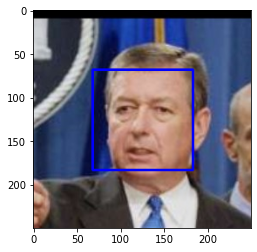

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[8])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

human_in_human_files = [face_detector(img) for img in human_files_short]
human_in_dog_files = [face_detector(img) for img in dog_files_short]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
    
print('percentage of human face in human files is {}%'.format(sum(human_in_human_files)))
print('percentage of human face in dog files is : {}%'.format(sum(human_in_dog_files)))

percentage of human face in human files is 98%
percentage of human face in dog files is : 12%


In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_in_human_files = [dog_detector(img) for img in human_files_short]
dog_in_dog_files = [dog_detector(img) for img in dog_files_short]

print('percentage of human face in human files is : {}%'.format(sum(dog_in_human_files)))
print('percentage of human face in dog files is : {}%'.format(sum(dog_in_dog_files)))

percentage of human face in human files is : 0%
percentage of human face in dog files is : 100%


In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 146.59it/s]


In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(16, kernel_size = (3,3), strides = (1,1), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (3,3),  activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(300, activation='relu'))

model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - ETA: 0s - loss: 4.8782 - accuracy: 0.0099
Epoch 00001: val_loss improved from inf to 4.84427, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 107s 320ms/step - loss: 4.8782 - accuracy: 0.0099 - val_loss: 4.8443 - val_accuracy: 0.0144
Epoch 2/5
334/334 [==============================] - ETA: 0s - loss: 4.8131 - accuracy: 0.0168
Epoch 00002: val_loss improved from 4.84427 to 4.78488, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 106s 318ms/step - loss: 4.8131 - accuracy: 0.0168 - val_loss: 4.7849 - val_accuracy: 0.0192
Epoch 3/5
334/334 [==============================] - ETA: 0s - loss: 4.7408 - accuracy: 0.0201
Epoch 00003: val_loss improved from 4.78488 to 4.69871, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 106s 317ms/step - loss: 4.7408 - accuracy: 0.0201 - val_lo

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.8278%


In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
322/334 [===========================>..] - ETA: 0s - loss: 8.0062 - accuracy: 0.2318
Epoch 00001: val_loss improved from inf to 3.51088, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 7.8565 - accuracy: 0.2392 - val_loss: 3.5109 - val_accuracy: 0.4491
Epoch 2/20
329/334 [============================>.] - ETA: 0s - loss: 2.2167 - accuracy: 0.5995
Epoch 00002: val_loss improved from 3.51088 to 2.59756, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 2.2191 - accuracy: 0.5993 - val_loss: 2.5976 - val_accuracy: 0.5629
Epoch 3/20
317/334 [===========================>..] - ETA: 0s - loss: 1.2352 - accuracy: 0.7366
Epoch 00003: val_loss improved from 2.59756 to 2.17173, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 1.2401 - accuracy: 0.7355 - val_loss: 2.1717 - val_accuracy: 0.6

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 75.2392%


In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [25]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [26]:
### TODO: Define your architecture.

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [27]:
### TODO: Compile the model.

ResNet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [28]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
314/334 [===========================>..] - ETA: 0s - loss: 1.6816 - accuracy: 0.5865
Epoch 00001: val_loss improved from inf to 0.87996, saving model to saved_models/weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 1.6259 - accuracy: 0.5970 - val_loss: 0.8800 - val_accuracy: 0.7210
Epoch 2/20
333/334 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.8628
Epoch 00002: val_loss improved from 0.87996 to 0.72946, saving model to saved_models/weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 0.4304 - accuracy: 0.8629 - val_loss: 0.7295 - val_accuracy: 0.7820
Epoch 3/20
313/334 [===========================>..] - ETA: 0s - loss: 0.2558 - accuracy: 0.9176
Epoch 00003: val_loss improved from 0.72946 to 0.67444, saving model to saved_models/weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 0.2590 - accuracy: 0.9168 - val_loss: 0.6744 - val_accu

In [29]:
### TODO: Load the model weights with the best validation loss.

ResNet_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [30]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet_predictions)==np.argmax(test_targets, axis=1))/len(ResNet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [32]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def predict_dog_breed(img_path):
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
        
    if face_detector(img_path):
        print("Human face detected")
    elif dog_detector(img_path):
        print("Dog detected")
    else:
        print("No human face or dog detected")
        
    breed = ResNet50_predict_breed(img_path)
    print("The image look like a ...\n",breed)
    

Human face detected
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 15s 0us/step
The image look like a ...
 German_shepherd_dog


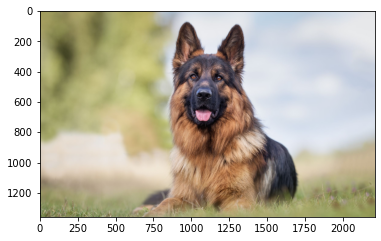

In [34]:
predict_dog_breed('images/german.jpg')

Dog detected
The image look like a ...
 Dachshund


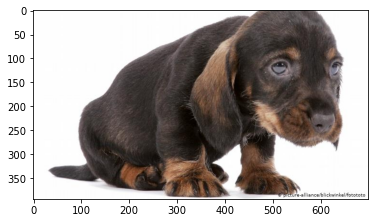

In [35]:
predict_dog_breed('images/pup.jpg')

Human face detected
The image look like a ...
 Pembroke_welsh_corgi


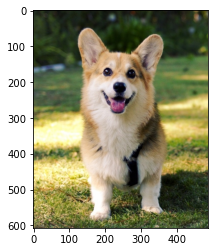

In [36]:
predict_dog_breed('images/WelshCorgi.jpeg')

Human face detected
The image look like a ...
 Nova_scotia_duck_tolling_retriever


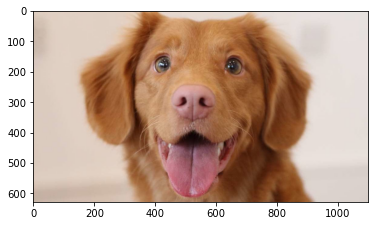

In [37]:
predict_dog_breed('images/pup2.jpg')

No human face or dog detected
The image look like a ...
 French_bulldog


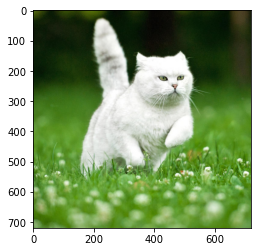

In [38]:
predict_dog_breed('images/Cat.jpg')

Human face detected
The image look like a ...
 Lowchen


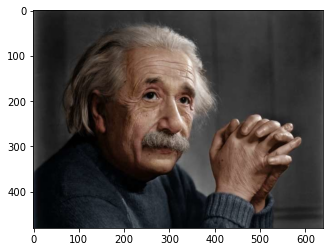

In [39]:
predict_dog_breed('images/Picture.jpg')

Dog detected
The image look like a ...
 Greater_swiss_mountain_dog


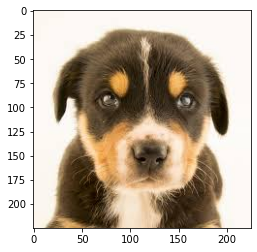

In [40]:
predict_dog_breed('images/puppy3.jpeg')